# **Procedimiento para realizar Solicitudes (requests) a la base de datos de EDAMAM mediante las API's :**

## **1. Recipe Search**
## **2. Nutrition Analysis**
## **3. Food Database**         

## *Por: Samuel Cortez / Maestría en Ciencia de Datos*

In [1]:
# Importar librerías
import pandas as pd
import requests     
import logging

In [2]:
# Se define clase Edamam_mcd
class Edamam_mcd:
    "API que regresa datos de tipo json"
    def __init__(self, 
                id_nutrition, 
                key_nutrition, 
                id_recipes,
                key_recipes,
                id_food,
                key_food):
        
        # Asignación de claves / ID de las API's
        self.id_nut = id_nutrition
        self.key_nut = key_nutrition
        self.id_rec = id_recipes
        self.key_rec = key_recipes
        self.id_food = id_food
        self.key_food = key_food
    
    def Nut_Analysis(self, query):
        self.Nut_ingredients = query
        # Se define url (Access Point) para realizar consulta a la API Nutrition Analysis
        url_req_nutr = 'https://api.edamam.com/api/nutrition-data'
        # Se definen los parametros a pasar por la función get para realizar consulta
        params_nutr= {
            'app_id':self.id_nut,
            'app_key':self.key_nut,
            'ingr':self.Nut_ingredients
            }
        # Envío de solicitud para realizar consulta de análisis nutricional
        Response = requests.get(url_req_nutr, params = params_nutr)

        # Imprimir el código del estatus
        print("Status Code (Nutrition Analysis API):", Response.status_code)
        
        if Response.status_code == 401:
            logging.error('{key} - Clave inválida (Nutrition Analysis API)'.format(key=self.key_nut))

        # Valor de retorno de tipo diccionario, Response tiene contenido JSON serializado
        self.r_Nut = Response.json()
        return self.r_Nut

    def Search_recipe(self, query):
        self.query_recipe = query
        # Se construye url con los parámetros para realizar consulta para busqueda de recetas de un platillo
        url_recipe = 'https://api.edamam.com/search?q={query}&app_id={id}&app_key={key}'.format(id=self.id_rec, key=self.key_rec,query=self.query_recipe)    
        Response = requests.get(url_recipe)

        # Imprimir el código de estatus
        print("Status Code (Recipe Search API) :", Response.status_code)
        
        if Response.status_code == 401:
            logging.error('{key} - Clave inválida (Recipe Search API)'.format(key=self.key_rec))

        # Valor de retorno de tipo diccionario, Response tiene contenido JSON serializado 
        self.r_Recipe = Response.json()
        return self.r_Recipe

    def Search_food(self, query):
        self.query_food = query
        # Se define url (Access Point) para realizar consulta de análisis de comida
        url_food = 'https://api.edamam.com/api/food-database/parser?'
        # Se definen los parametros a pasar por la función get para realizar consulta
        params_food = {
            'app_id':self.id_food,
            'app_key':self.key_food,
            'ingr':self.query_food
            }
        # Se realiza una consulta dando la url
        Response = requests.get(url_food, params= params_food)
        
        # Imprimir el código de estatus
        print("Status Code (Food Database API):", Response.status_code)

        if Response.status_code == 401:
            logging.error('{key} - Clave inválida (Food Database API)'.format(key=self.key_rec))

        # Valor de retorno de tipo diccionario, Response tiene contenido JSON serializado
        self.r_Food = Response.json()
        return self.r_Food
    
    # Conjunto de funciones para generar dataframes con los datos principales de las consultas

    def Nutrient_Guide(self):
        # Manejo de excepciones
        try:
            # Se crean DataFrames de las variables totalNutrients, totalDaily y totalNutrientsKCal 
            self.df_Nutrition= pd.DataFrame(self.r_Nut.get('totalNutrients')).T.rename_axis(str(self.Nut_ingredients))
            self.df_totalDaily = pd.DataFrame(self.r_Nut.get('totalDaily')).T.rename_axis(str(self.Nut_ingredients))
            self.df_total_Nut =  pd.DataFrame(Response_Nut.get('totalNutrientsKCal')).T.rename_axis(str(self.Nut_ingredients))
            # Se obtiene las calorías del alimento
            self.Nutrient_Cal = self.r_Nut.get('calories')
            # Se obtiene el peso total del alimento
            self.totalWeight = self.r_Nut.get('totalWeight')
            
        except Exception as e:
            print(e)
        
    def ingredients_table(self):
        # Manejo de excepciones
        try:
            # Comprensión de listas: se crean nuevas listas con las etiquetas de la receta y con los ingredientes
            list_label = [element_hits.get('recipe').get('label') for element_hits in Response_Recipe.get('hits')]
            list_ingredientes = [element_ingre.get('recipe').get('ingredients') for element_ingre in Response_Recipe.get('hits')]
            # Se construye DataFrame 
            df_ = pd.DataFrame(list_ingredientes, index=list_label).stack().apply(pd.Series).drop(columns=['foodId'])
            self.df_Recipe = df_.rename_axis(["Types", "Items"], axis = "rows").rename(columns = {"foodCategory": "food category", "text":"ingredient name"})

        except Exception as e:
            print(e)

    def food_table(self):
        # Se generar listas vacias
        list_foods = []
        list_nutrients = []
        rename_nutrients = ['ENERGY (kcal)', 'PROTEIN (g)', 'FAT (g)', 'CARBS (g)', 'FIBER (g)']
        # Manejo de excepciones
        try:
            # Comprensión de listas: se crean nuevas listas con las etiquetas de los alimentos y con los nutrientes  
            list_foods = [element.get('food').get('label') for  element in self.r_Food['hints']]
            list_nutrients = [element.get('food').get('nutrients') for element in self.r_Food['hints']]
            # Se construye DataFrame
            self.df_food_table = pd.DataFrame(list_nutrients, index = list_foods).round(2).fillna('Unknown')
            self.df_food_table.columns = rename_nutrients
            
        except Exception as e:
            print(e) 
    
    def write_files(self):
        #  Exportar archivos .CSV/.xlsx
        path_Nutrition = '{Nut}_Nutritional_Analysis.xlsx'.format(Nut=self.Nut_ingredients)
        path_Recipe = '{Recipe}_Recipe.csv'.format(Recipe = self.query_recipe)
        path_food = '{food}_food.csv'.format(food = self.query_food)

        # Se exporta a excel el análisis nutricional 
        with pd.ExcelWriter(path_Nutrition) as writer:
            self.df_Nutrition.to_excel(writer, sheet_name= 'Nutritional_Analysis')
            self.df_totalDaily.to_excel(writer, sheet_name='Total_Daily')
            self.df_total_Nut.to_excel(writer, sheet_name='totalNutrientsKCal')
        # Se exporta en formato CSV los ingredientes de las recetas
        self.df_Recipe.to_csv(path_Recipe)
        # Se exporta en CSV el dataframe con el análisis de los alimentos
        self.df_food_table.to_csv(path_food)
        

In [20]:
# Claves / ID's de las aplicaciones asignadas
nutrition_appid= '5f1e7888'
nutrition_appkey= '5576413f5acb38f5259a58dad888d1b9'
recipes_appid = 'dcda2d5e'
recipes_appkey= '87ae2d34cdde47026fc341c8fbd7957f'
food_appid= '6b69c52c'
food_appkey= 'd5a448b534a0c358dfb47fa7a6548724'

# Se crea el objeto EDAMAM_consulta
EDAMAM_consulta = Edamam_mcd(id_nutrition=nutrition_appid, 
                            key_nutrition= nutrition_appkey,
                            id_recipes=recipes_appid,
                            key_recipes=recipes_appkey,
                            id_food=food_appid,
                            key_food=food_appkey)

# Ejercución de los métodos de cada una de las API's para realizar consultas
Response_Nut = EDAMAM_consulta.Nut_Analysis(query= '1 egg')
Response_Food = EDAMAM_consulta.Search_food(query= 'salad')
Response_Recipe = EDAMAM_consulta.Search_recipe(query= 'salad')
# Ejecución de los métodos para obtener los dataframe con los resultados para cada una de las API's
EDAMAM_consulta.Nutrient_Guide()
EDAMAM_consulta.ingredients_table()
EDAMAM_consulta.food_table()
# Se exportan en archivos csv y xlsx los resultados obtenidos
EDAMAM_consulta.write_files()


Status Code (Nutrition Analysis API): 200
Status Code (Food Database API): 200
Status Code (Recipe Search API) : 200


In [4]:
# Consulta a la API: Nutrition Analysis obtenida en formato json
print(Response_Nut)

{'uri': 'http://www.edamam.com/ontologies/edamam.owl#recipe_2668da86ce1d4e07b94b017088c26c5b', 'calories': 61, 'totalWeight': 43.0, 'dietLabels': ['LOW_CARB', 'LOW_SODIUM'], 'healthLabels': ['LOW_FAT_ABS', 'SUGAR_CONSCIOUS', 'LOW_POTASSIUM', 'KIDNEY_FRIENDLY', 'KETO_FRIENDLY', 'VEGETARIAN', 'PESCATARIAN', 'PALEO', 'SPECIFIC_CARBS', 'MEDITERRANEAN', 'DAIRY_FREE', 'GLUTEN_FREE', 'WHEAT_FREE', 'MILK_FREE', 'PEANUT_FREE', 'TREE_NUT_FREE', 'SOY_FREE', 'FISH_FREE', 'SHELLFISH_FREE', 'PORK_FREE', 'RED_MEAT_FREE', 'CRUSTACEAN_FREE', 'CELERY_FREE', 'MUSTARD_FREE', 'SESAME_FREE', 'LUPINE_FREE', 'MOLLUSK_FREE', 'ALCOHOL_FREE', 'NO_OIL_ADDED', 'NO_SUGAR_ADDED', 'SULPHITE_FREE', 'FODMAP_FREE', 'KOSHER'], 'cautions': [], 'totalNutrients': {'ENERC_KCAL': {'label': 'Energy', 'quantity': 61.49, 'unit': 'kcal'}, 'FAT': {'label': 'Fat', 'quantity': 4.0893, 'unit': 'g'}, 'FASAT': {'label': 'Saturated', 'quantity': 1.34418, 'unit': 'g'}, 'FATRN': {'label': 'Trans', 'quantity': 0.01634, 'unit': 'g'}, 'FAMS'

In [5]:
# Consulta a la API: Food Database obtenida en formato json
Response_Food.items()

dict_items([('text', 'pizza'), ('parsed', [{'food': {'foodId': 'food_at830s9amds32fb8w6ufmaopzk8n', 'label': 'Pizza', 'nutrients': {'ENERC_KCAL': 268.0, 'PROCNT': 10.36, 'FAT': 12.28, 'CHOCDF': 29.02, 'FIBTG': 2.2}, 'category': 'Generic foods', 'categoryLabel': 'food', 'image': 'https://www.edamam.com/food-img/c01/c0150280d71059c23c025f501f502dc0.jpg'}}]), ('hints', [{'food': {'foodId': 'food_at830s9amds32fb8w6ufmaopzk8n', 'label': 'Pizza', 'nutrients': {'ENERC_KCAL': 268.0, 'PROCNT': 10.36, 'FAT': 12.28, 'CHOCDF': 29.02, 'FIBTG': 2.2}, 'category': 'Generic foods', 'categoryLabel': 'food', 'image': 'https://www.edamam.com/food-img/c01/c0150280d71059c23c025f501f502dc0.jpg'}, 'measures': [{'uri': 'http://www.edamam.com/ontologies/edamam.owl#Measure_unit', 'label': 'Whole'}, {'uri': 'http://www.edamam.com/ontologies/edamam.owl#Measure_pizza', 'label': 'Pizza'}, {'uri': 'http://www.edamam.com/ontologies/edamam.owl#Measure_serving', 'label': 'Serving'}, {'uri': 'http://www.edamam.com/ontolo

In [117]:
# Consulta a la API: Recipe Search obtenida en formato json / Habilitar para mostrar la respuesta es demasiado larga
# Response_Recipe

## **Despliegue de los DataFrames de la API Nutrition Analysis**

In [21]:
# Desplegar DataFrame de Nutrientes totales en kCal
EDAMAM_consulta.df_total_Nut

,label,quantity,unit
1 egg,,,
ENERC_KCAL,Energy,61,kcal
PROCNT_KCAL,Calories from protein,22,kcal
FAT_KCAL,Calories from fat,38,kcal
CHOCDF_KCAL,Calories from carbohydrates,1,kcal


In [22]:
# Desplegar DataFrame de nutrientes totales 
EDAMAM_consulta.df_Nutrition 

,label,quantity,unit
1 egg,,,
ENERC_KCAL,Energy,61.49,kcal
FAT,Fat,4.0893,g
FASAT,Saturated,1.34418,g
FATRN,Trans,0.01634,g
FAMS,Monounsaturated,1.57294,g
FAPU,Polyunsaturated,0.82173,g
CHOCDF,Carbs,0.3096,g
FIBTG,Fiber,0,g
SUGAR,Sugars,0.1591,g


In [8]:
# Desplegar DataFrame de nutrientes total diario
EDAMAM_consulta.df_totalDaily 

,label,quantity,unit
1 egg,,,
ENERC_KCAL,Energy,3.0745,%
FAT,Fat,6.29123,%
FASAT,Saturated,6.7209,%
CHOCDF,Carbs,0.1032,%
FIBTG,Fiber,0,%
PROCNT,Protein,10.8016,%
CHOLE,Cholesterol,53.32,%
NA,Sodium,2.54417,%
CA,Calcium,2.408,%


In [23]:
# Registro de Calorias
print('Calorías:',EDAMAM_consulta.Nutrient_Cal)

Calorías: 61


In [10]:
# Registro del peso total en gramos/ en este peso se basa todo el análisis nutricional
print('Peso total: {wtotal} g:'.format(wtotal = EDAMAM_consulta.totalWeight))

Peso total: 43.0 g:


## **Despliegue de los DataFrames de la API Food Database**

In [24]:
# Desplegar DataFrame de la base de datos de alimentos solicitadas
EDAMAM_consulta.df_food_table

,ENERGY (kcal),PROTEIN (g),FAT (g),CARBS (g),FIBER (g)
Salad Lovers Salad,91.00,6.82,0.00,13.65,9.10
Salads Tuna Salad,246.48,10.56,9.86,30.28,2.11
Hawaiian Salad,184.32,4.46,14.63,9.99,0.67
"Salad Extra, Tuna Salad",114.64,22.05,2.65,0.00,0.00
"Salad Bar, Caponata Salad",59.17,1.69,4.23,6.76,1.69
"Salad Bar, Cucumber Salad",135.26,0.00,11.83,5.07,0.00
"Salad Bar, Macaroni Salad",185.98,3.38,13.53,11.83,1.69
"Salad Bar, Panzenella Salad",219.79,3.38,13.53,20.29,1.69
"Pasta Salad, Salad Bar",185.84,4.42,7.08,25.66,1.77
"Salad Bar, Broccoli Salad",56.36,1.41,3.52,5.64,1.41


## **Despliegue de los DataFrames de la API Recipe Search**

In [25]:
# Desplegar DataFrame para la búsqueda de recetas
EDAMAM_consulta.df_Recipe

ingredient name  \
Types                               Items                                                      
Zuni-Inspired Grilled Chicken Salad 0             1 pound boneless, skinless chicken breasts   
                                    1      3/4 teaspoon kosher salt, divided, plus more f...   
                                    2            1 tablespoon olive oil, plus more for salad   
                                    3      1/4 cup aioli or 1/4 cup mayo + 1 small garlic...   
                                    4         Zest and juice of 1 lemon, plus more for salad   
...                                                                                      ...   
Quinoa Salad                        6      1 tablespoon fines herbs (recommended: Spice I...   
                                    7                           1/4 cup crumbled feta cheese   
                                    8                         3 tablespoons slivered almonds   
                                    9                                9 cups spring salad mix   
                                    10     1/4 cup light roasted garlic and balsamic sala...   

                                           quantity     measure  \
Types                               Items                         
Zuni-Inspired Grilled Chicken Salad 0          1.00       pound   
                                    1          0.75    teaspoon   
                                    2          1.00  tablespoon   
                                    3          0.25         cup   
                                    4          1.00      <unit>   
...                                             ...         ...   
Quinoa Salad                        6          1.00  tablespoon   
                                    7          0.25         cup   
                                    8          3.00  tablespoon   
                                    9          9.00         cup   
                                    10         0.25         cup   

                                                                         food  \
Types                               Items                                       
Zuni-Inspired Grilled Chicken Salad 0      boneless, skinless chicken breasts   
                                    1                             kosher salt   
                                    2                               olive oil   
                                    3                                   aioli   
                                    4                                   lemon   
...                                                                       ...   
Quinoa Salad                        6                                   herbs   
                                    7                             feta cheese   
                                    8                                 almonds   
                                    9                               salad mix   
                                    10                         salad dressing   

                                               weight          food category  \
Types                               Items                                      
Zuni-Inspired Grilled Chicken Salad 0      453.592370                Poultry   
                                    1        3.640625  Condiments and sauces   
                                    2       13.500000                   Oils   
                                    3       57.750000  condiments and sauces   
                                    4       58.000000                  fruit   
...                                               ...                    ...   
Quinoa Salad                        6        2.700000  Condiments and sauces   
                                    7       37.500000                 Cheese   
                                    8       26.812500    plant-based protein   
                      

In [46]:
food = EDAMAM_consulta.df_Recipe

In [64]:
import matplotlib.pyplot as plt

<AxesSubplot:title={'center':'Zuni-Inspired Grilled Chicken Salad'}, ylabel='ingredient name'>

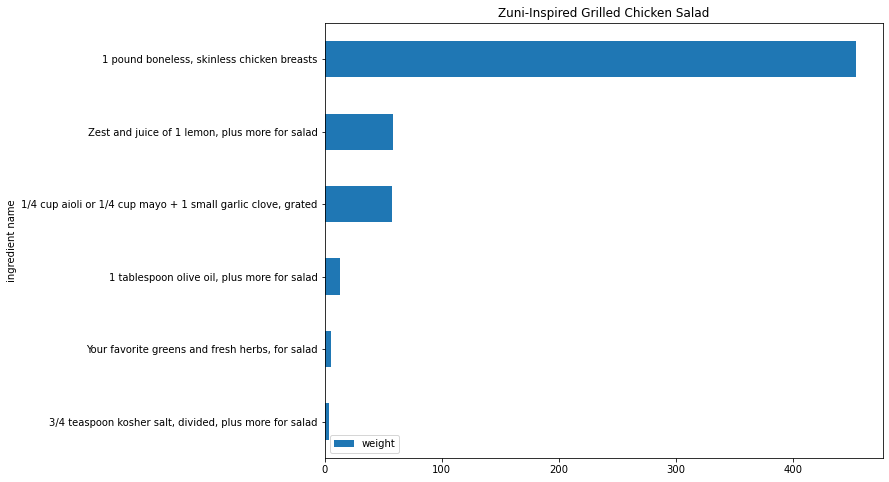

In [65]:
%matplotlib inline
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10,8) ) 
food.loc['Zuni-Inspired Grilled Chicken Salad',['ingredient name','weight']].sort_values('weight', ascending = True).plot(kind = 'barh', x = 'ingredient name',
                                                                                                                             y = 'weight', title = 'Zuni-Inspired Grilled Chicken Salad', ax = axs)

In [115]:
EDAMAM_consulta.r_Recipe['hits']

[{'recipe': {'uri': 'http://www.edamam.com/ontologies/edamam.owl#recipe_b20815eac65ee2fa5f848f56c16056dd',
   'label': 'Zuni-Inspired Grilled Chicken Salad',
   'image': 'https://www.edamam.com/web-img/3ac/3accba1eeb5ac38d902d056050c05ead.jpg',
   'source': 'Food52',
   'url': 'https://food52.com/recipes/82361-zuni-inspired-grilled-chicken-salad-recipe',
   'shareAs': 'http://www.edamam.com/recipe/zuni-inspired-grilled-chicken-salad-b20815eac65ee2fa5f848f56c16056dd/salad',
   'yield': 4.0,
   'dietLabels': ['Low-Carb'],
   'healthLabels': ['Sugar-Conscious',
    'Keto-Friendly',
    'Paleo',
    'Dairy-Free',
    'Gluten-Free',
    'Wheat-Free',
    'Peanut-Free',
    'Tree-Nut-Free',
    'Soy-Free',
    'Fish-Free',
    'Shellfish-Free',
    'Pork-Free',
    'Red-Meat-Free',
    'Crustacean-Free',
    'Celery-Free',
    'Sesame-Free',
    'Lupine-Free',
    'Mollusk-Free',
    'Alcohol-Free',
    'Sulfite-Free',
    'Kosher'],
   'cautions': ['Sulfites'],
   'ingredientLines': ['1 pou

In [104]:
nutr = EDAMAM_consulta.r_Recipe['hits'][0]['recipe']['totalDaily']
nutr

{'ENERC_KCAL': {'label': 'Energy',
  'quantity': 54.110609139100035,
  'unit': '%'},
 'FAT': {'label': 'Fat', 'quantity': 107.80300346246928, 'unit': '%'},
 'FASAT': {'label': 'Saturated', 'quantity': 55.44708309317001, 'unit': '%'},
 'CHOCDF': {'label': 'Carbs', 'quantity': 1.9256145786117058, 'unit': '%'},
 'FIBTG': {'label': 'Fiber', 'quantity': 7.270157553400242, 'unit': '%'},
 'PROCNT': {'label': 'Protein', 'quantity': 205.74093739903014, 'unit': '%'},
 'CHOLE': {'label': 'Cholesterol',
  'quantity': 117.88164336666667,
  'unit': '%'},
 'NA': {'label': 'Sodium', 'quantity': 57.04278413915544, 'unit': '%'},
 'CA': {'label': 'Calcium', 'quantity': 4.650017121305595, 'unit': '%'},
 'MG': {'label': 'Magnesium', 'quantity': 32.04752751172694, 'unit': '%'},
 'K': {'label': 'Potassium', 'quantity': 34.634795096106984, 'unit': '%'},
 'FE': {'label': 'Iron', 'quantity': 13.736402374463049, 'unit': '%'},
 'ZN': {'label': 'Zinc', 'quantity': 28.946504489911305, 'unit': '%'},
 'P': {'label': 

In [112]:
[nutr.get(element).get('quantity') for element in nutr]


[54.110609139100035,
 107.80300346246928,
 55.44708309317001,
 1.9256145786117058,
 7.270157553400242,
 205.74093739903014,
 117.88164336666667,
 57.04278413915544,
 4.650017121305595,
 32.04752751172694,
 34.634795096106984,
 13.736402374463049,
 28.946504489911305,
 139.83333563871446,
 6.335822221056421,
 42.82247092611384,
 37.88504846308348,
 63.09277140392321,
 272.99920460777207,
 286.94711289653867,
 14.029463706000705,
 39.689332375,
 0.0,
 30.722356644166762,
 87.68116326669193]

In [114]:
[nutr.get(element).get('label') for element in nutr]

['Energy',
 'Fat',
 'Saturated',
 'Carbs',
 'Fiber',
 'Protein',
 'Cholesterol',
 'Sodium',
 'Calcium',
 'Magnesium',
 'Potassium',
 'Iron',
 'Zinc',
 'Phosphorus',
 'Vitamin A',
 'Vitamin C',
 'Thiamin (B1)',
 'Riboflavin (B2)',
 'Niacin (B3)',
 'Vitamin B6',
 'Folate equivalent (total)',
 'Vitamin B12',
 'Vitamin D',
 'Vitamin E',
 'Vitamin K']

In [140]:
food_list = []
nutrient_list = []
nutrient_label_list = []
for element in EDAMAM_consulta.r_Recipe['hits']:
    #print(element)
    food_list.append(element.get('recipe').get('label'))
    #nutrient_list.append(element.get('recipe').get('totalDaily').get('quantity'))
    nutrient_list.append([ element.get('recipe').get('totalDaily').get(nutr_element).get('quantity') for nutr_element in element.get('recipe').get('totalDaily')][:6])

nutrient_label_list = [ element.get('recipe').get('totalDaily').get(nutr_element).get('label') for nutr_element in EDAMAM_consulta.r_Recipe['hits'][0].get('recipe').get('totalDaily')]
food_list, nutrient_list, nutrient_label_list[:6]

(['Zuni-Inspired Grilled Chicken Salad',
  'Steak & Chips Salad',
  'Shrimp Salad',
  'Strawberry Hazelnut Salad',
  'Grilled Tofu Salad With Miso Dressing',
  'Chicken Salad-Stuffed Tomatoes',
  'Buffalo Chicken Salad',
  'Buffalo Chicken Salad recipes',
  'Washing up free salad',
  'Quinoa Salad'],
 [[54.110609139100035,
   107.80300346246928,
   55.44708309317001,
   1.9256145786117058,
   7.270157553400242,
   205.74093739903014],
  [146.11524999995262,
   189.71342307684193,
   223.61651249998312,
   105.67358749996932,
   259.54799999974745,
   330.81644999988185],
  [66.01678623730206,
   176.38993086274672,
   80.27098735535544,
   2.514101734608906,
   3.2443162353161235,
   124.40628646745604],
  [82.46156036305557,
   230.23709288279917,
   92.69111461986111,
   24.55396246119676,
   83.56690414277777,
   34.99509147518056],
  [44.040065971874995,
   95.33416589384616,
   37.075169062437496,
   9.667438308041667,
   45.043785785,
   134.5975729755],
  [6.131802500000001,
   

In [160]:
food_list
food_list = ['Grilled Chicken','Steak & Chips','Shrimp','Strawberry', 'Salad With Miso Dressing','Chicken- Stuffed', 'Buffalo Chicken','Buffalo Chicken recipes','Washing up free','Quinoa' ]

In [184]:
df_food = pd.DataFrame(nutrient_list, columns = nutrient_label_list[:6], index =food_list )
df_food

,Energy,Fat,Saturated,Carbs,Fiber,Protein
Grilled Chicken,54.110609,107.803003,55.447083,1.925615,7.270158,205.740937
Steak & Chips,146.115250,189.713423,223.616512,105.673587,259.548000,330.816450
Shrimp,66.016786,176.389931,80.270987,2.514102,3.244316,124.406286
Strawberry,82.461560,230.237093,92.691115,24.553962,83.566904,34.995091
Salad With Miso Dressing,44.040066,95.334166,37.075169,9.667438,45.043786,134.597573
Chicken- Stuffed,6.131803,8.937651,7.963808,3.426991,12.969260,17.693269
Buffalo Chicken,163.020100,375.799754,309.961695,7.482917,31.898400,464.740140
Buffalo Chicken recipes,163.020100,375.799754,309.961695,7.482917,31.898400,464.740140
Washing up free,22.250328,56.430274,21.652598,11.044646,66.917125,16.674681
Quinoa,73.418569,107.826448,76.757581,54.838608,96.210250,110.647927


In [210]:
fig, axs_scat = plt.subplots(nrows=1, ncols=1)
colors = ['r', 'k', 'g', 'b','c', 'm', 'y', 'brown', 'maroon', 'gold']
for k, i in enumerate(food_list):
    print(k,i)
    df_food.loc[[i],:].plot(kind = 'scatter', x = 'Protein', y = 'Energy', ax = axs_scat, c = colors[k], marker = '*')

axs_scat.legend(food_list)


0 Grilled Chicken
1 Steak & Chips
2 Shrimp
3 Strawberry
4 Salad With Miso Dressing
5 Chicken- Stuffed
6 Buffalo Chicken
7 Buffalo Chicken recipes
8 Washing up free
9 Quinoa


In [162]:
%matplotlib qt
figs, axs_nut = plt.subplots(nrows=1, ncols=1, figsize = (10,25))
df_food[['Carbs', 'Protein', 'Fat']].plot.bar(rot =0, ax = axs_nut)
plt.xticks(rotation = 45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Grilled Chicken'),
  Text(1, 0, 'Steak & Chips'),
  Text(2, 0, 'Shrimp'),
  Text(3, 0, 'Strawberry'),
  Text(4, 0, 'Salad With Miso Dressing'),
  Text(5, 0, 'Chicken- Stuffed'),
  Text(6, 0, 'Buffalo Chicken'),
  Text(7, 0, 'Buffalo Chicken recipes'),
  Text(8, 0, 'Washing up free'),
  Text(9, 0, 'Quinoa')])

In [175]:
EDAMAM_consulta.r_Recipe['hits'][0]['recipe']['totalNutrients']

{'ENERC_KCAL': {'label': 'Energy',
  'quantity': 1082.2121827820008,
  'unit': 'kcal'},
 'FAT': {'label': 'Fat', 'quantity': 70.07195225060502, 'unit': 'g'},
 'FASAT': {'label': 'Saturated', 'quantity': 11.089416618634003, 'unit': 'g'},
 'FATRN': {'label': 'Trans', 'quantity': 0.031751465900000005, 'unit': 'g'},
 'FAMS': {'label': 'Monounsaturated',
  'quantity': 24.14441767765251,
  'unit': 'g'},
 'FAPU': {'label': 'Polyunsaturated',
  'quantity': 30.083229037938004,
  'unit': 'g'},
 'CHOCDF': {'label': 'Carbs', 'quantity': 5.776843735835117, 'unit': 'g'},
 'FIBTG': {'label': 'Fiber', 'quantity': 1.8175393883500608, 'unit': 'g'},
 'SUGAR': {'label': 'Sugars', 'quantity': 1.4998510545750157, 'unit': 'g'},
 'PROCNT': {'label': 'Protein', 'quantity': 102.87046869951507, 'unit': 'g'},
 'CHOLE': {'label': 'Cholesterol', 'quantity': 353.6449301, 'unit': 'mg'},
 'NA': {'label': 'Sodium', 'quantity': 1369.0268193397305, 'unit': 'mg'},
 'CA': {'label': 'Calcium', 'quantity': 46.50017121305595,

In [182]:
data = {'# Meal Plans':[2,4,5,3,7]}
date_time = pd.date_range('2021/10/10', periods= 5)
meal_plans_df = pd.DataFrame(data, index = date_time)
meal_plans_df

,# Meal Plans
2021-10-10,2
2021-10-11,4
2021-10-12,5
2021-10-13,3
2021-10-14,7


In [183]:
meal_plans_df.plot(kind = 'line')

<AxesSubplot:>